# Soda Lake 3D 3C Seismic Data Processing Tutorial
This tutorial walks through accessing and exploring SEG-Y seismic data from the Soda Lake geothermal field near Fallon, Nevada. The dataset was collected in 2010 by Magma Energy (now CYRQ Energy) as a petroleum-industry-quality, three-dimensional (3D) and three-component (3C) seismic reflection survey spanning roughly 36 square miles. Each shot record contains three geophone components for all active sensors, saved as hundreds of SEG-Y files in a bucket on Amazon S3. Beyond the shot data, additional folders provide field logs, metadata, and survey reports.

More dataset information is found at its location in the Geothermal Data Repository (GDR):
https://gdr.openei.org/submissions/1655.

## Step 1: Environment Setup
This section ensures that all necessary Python libraries are installed and imported, and that your environment is correctly configured for the tutorial.

In [1]:
# For demonstration, we’ll show how to install packages right within the notebook.
# (You can also do this in a terminal or conda environment if you prefer.)
# Uncomment the following line to install if needed. You may need a restart of the kernel afterward.

# !pip install boto3 botocore obspy matplotlib numpy pandas folium pyproj

In [17]:
import os
import sys
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Boto3 and botocore for S3 access
import boto3
import botocore

# ObsPy for SEG-Y reading and seismic data handling
import obspy
from obspy.io.segy.core import _read_segy

# For geospatial plotting
import folium
from pyproj import Transformer

# If you want S3 debug info, set the logger:
boto3.set_stream_logger('boto3', logging.INFO)

## Step 2: S3 Initialization and Basic Inspection
Here, you initialize an S3 resource to connect to the 'gdr-data-lake' bucket. You also verify bucket access and list a few objects within the Soda Lake dataset to understand what files are available.

In [7]:
# Create an S3 resource with unsigned requests (public data)
s3 = boto3.resource('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

# Specify the bucket name corresponding to the data
bucket_name = 'gdr-data-lake'
bucket = s3.Bucket(bucket_name)

# Check the bucket to ensure it is accessible
try:
    response = s3.meta.client.head_bucket(Bucket=bucket_name)
    print(f"Bucket '{bucket_name}' is accessible.")
except botocore.exceptions.ClientError as e:
    print(f"Unable to access bucket '{bucket_name}'. Error: {e}")

# Count how many objects are within the specific prefix for Soda Lake data
prefix = 'soda_lake/raw_seismic/2010/v1.0.0'
count = 0
max_print = 5 # we just print a handful of keys for demonstration
print_count = 0

print(f"Listing {max_print} objects from prefix: '{prefix}'")
for obj in bucket.objects.filter(Prefix=prefix):
    count += 1
    if print_count < max_print:
        print(f"  {obj.key}")
        print_count += 1

print(f"\nTotal number of objects in '{prefix}' is: {count}")

Bucket 'gdr-data-lake' is accessible.
Listing 5 objects from prefix: 'soda_lake/raw_seismic/2010/v1.0.0'
  soda_lake/raw_seismic/2010/v1.0.0/
  soda_lake/raw_seismic/2010/v1.0.0/F1000R1.SGY
  soda_lake/raw_seismic/2010/v1.0.0/F1001R1.SGY
  soda_lake/raw_seismic/2010/v1.0.0/F1002R1.SGY
  soda_lake/raw_seismic/2010/v1.0.0/F1003R1.SGY

Total number of objects in 'soda_lake/raw_seismic/2010/v1.0.0' is: 8322


## Step 3: Selecting Files to Access and Reading/Downloading them from S3
In this step, we'll demonstrate two options to access the data:
- Option A: Directly read from S3 (if the bucket is publicly accessible with HTTP endpoints).
- Option B: Download to your local system, then read from disk.

In [9]:
# Define the S3 keys (paths) for the SEG-Y files under the specified prefix
file_keys = [
    'soda_lake/raw_seismic/2010/v1.0.0/F1000R1.SGY',
    'soda_lake/raw_seismic/2010/v1.0.0/F1001R1.SGY',
    'soda_lake/raw_seismic/2010/v1.0.0/F1002R1.SGY',
    'soda_lake/raw_seismic/2010/v1.0.0/F1003R1.SGY'
]

# For demonstration, we'll just pick the first file in the list
selected_key = file_keys[0]
print(f"Selected file key: {selected_key}")

Selected file key: soda_lake/raw_seismic/2010/v1.0.0/F1000R1.SGY


### Option A: Read the Data Directly from S3

In [10]:
# We'll build the URL for public S3 access 
direct_url = f"https://{bucket_name}.s3.amazonaws.com/{selected_key}"
print(f"Attempting direct read of: {direct_url}")

try:
    data_stream_s3 = obspy.read(direct_url, format='SEGY')
    print("Success: Data was read directly from S3 using HTTP.")
except Exception as e:
    print("Failed to read directly from S3.")
    print(f"Error: {e}")
    data_stream_s3 = None

Attempting direct read of: https://gdr-data-lake.s3.amazonaws.com/soda_lake/raw_seismic/2010/v1.0.0/F1000R1.SGY
Success: Data was read directly from S3 using HTTP.


### Option B: Local Download and Read

In [11]:
# We'll download the same file, store it locally, then read it from disk.
# You can choose a different directory if you prefer.
local_download_path = os.path.join(os.getcwd(), 'SodaLake_data')
os.makedirs(local_download_path, exist_ok=True)
local_file_path = os.path.join(local_download_path, os.path.basename(selected_key))

try:
    print(f"\nDownloading to {local_file_path}")
    bucket.download_file(selected_key, local_file_path)
    print("File downloaded successfully.")
    
    # Read using _read_segy or obspy.read
    data_stream_local = obspy.io.segy.core._read_segy(local_file_path)
    print("Success: Data was read from local file.")
    
    # Optional: print a summary
    print(data_stream_local)
except botocore.exceptions.ClientError as e:
    print(f"Error: {e}")
    data_stream_local = None


File downloaded successfully.
Success: Data was read from local file.
2602 Trace(s) in Stream:

Seq. No. in line:    1 | 2010-06-21T14:23:04.000000Z - 2010-06-21T14:23:07.998000Z | 500.0 Hz, 2000 samples
...
(2600 other traces)
...
Seq. No. in line: 2602 | 2010-06-21T14:23:04.000000Z - 2010-06-21T14:23:07.998000Z | 500.0 Hz, 2000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


## Step 4: Basic SEG-Y File Parsing and Metadata Exploration
In this step, you use ObsPy to read SEG-Y files, unpack their headers, and examine metadata—such as sample rate, time ranges, and trace header information.

In [12]:
# Reload the file with header unpacking for more detailed metadata
# We'll choose the local file path from Step 3
# If you already have a data stream from Option A (direct read), you could skip reloading.
# But for demonstration, let's do a new read with unpack_trace_headers set to True.

try: 
    data = _read_segy(local_file_path, unpack_trace_headers=True)
    print("Successfully reloaded file with unpacked headers:")
    print(data)
except Exception as e:
    print("Unable to read local file path with unpacked headers. Eror:")
    print(e)
    data = None

Successfully reloaded file with unpacked headers:
2602 Trace(s) in Stream:

Seq. No. in line:    1 | 2010-06-21T14:23:04.000000Z - 2010-06-21T14:23:07.998000Z | 500.0 Hz, 2000 samples
...
(2600 other traces)
...
Seq. No. in line: 2602 | 2010-06-21T14:23:04.000000Z - 2010-06-21T14:23:07.998000Z | 500.0 Hz, 2000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [14]:
# Inspect the data stream
if data is not None:
    # print first trace to see a summary
    print("\nShowing the first trace's summary and stats:")
    print(data[0])  # This includes start time, sample rate, etc.

    # Check sampling rate and timing info
    print(f"\nSampling Rate: {data[0].stats.sampling_rate} Hz")
    print(f"Start Time of first trace: {data[0].stats.starttime}")
    print(f"Number of Traces in this Stream: {len(data)}")
    
# Extract detailed trace header info into a DataFrame
    headers_list = []
    for trace in data:
        trace_header = trace.stats.segy.trace_header  # Dictionary-like object
        headers_list.append(pd.Series(trace_header))

    headers_df = pd.DataFrame(headers_list)
    print("\nTrace Headers DataFrame (showing first 5 rows):")
    display(headers_df.head())

    # (Optional) Save the DataFrame to a CSV for future reference
    # headers_df.to_csv("SodaLake_trace_headers.csv", index=False)
    # print("Saved headers to 'SodaLake_trace_headers.csv'.")
else:
    print("\nSkipping header analysis since data is None.")


Showing the first trace's summary and stats:
Seq. No. in line:    1 | 2010-06-21T14:23:04.000000Z - 2010-06-21T14:23:07.998000Z | 500.0 Hz, 2000 samples

Sampling Rate: 500.0 Hz
Start Time of first trace: 2010-06-21T14:23:04.000000Z
Number of Traces in this Stream: 2602

Trace Headers DataFrame (showing first 5 rows):


endian unpacked_header  trace_sequence_number_within_line  \
0      >            None                                  1   
1      >            None                                  2   
2      >            None                                  3   
3      >            None                                  4   
4      >            None                                  5   

   trace_sequence_number_within_segy_file  original_field_record_number  \
0                                       1                          1000   
1                                       2                          1000   
2                                       3                          1000   
3                                       4                          1000   
4                                       5                          1000   

   trace_number_within_the_original_field_record  energy_source_point_number  \
0                                              1                           1   
1                                              2                           1   
2                                              3                           1   
3                                              4                           1   
4                                              5                           1   

   ensemble_number  trace_number_within_the_ensemble  \
0                0                                 0   
1                0                                 0   
2                0                                 0   
3                0                                 0   
4                0                                 0   

   trace_identification_code  ...  transduction_units  \
0                          8  ...                   0   
1                          1  ...                   0   
2                          1  ...                   0   
3                          1  ...                   0   
4                          1  ...                   0   

   device_trace_identifier  scalar_to_be_applied_to_times  \
0                        0                              7   
1                        0                            639   
2                        0                           1930   
3                        0                           1223   
4                        0                            588   

   source_type_orientation  source_energy_direction_mantissa  \
0                        0                                 0   
1                        0                                 0   
2                        0                                 0   
3                        0                                 0   
4                        0                                 0   

   source_energy_direction_exponent  source_measurement_mantissa  \
0                                 0                            0   
1                                 0                            0   
2                                 0                            0   
3                                 0                            0   
4                                 0                            0   

   source_measurement_exponent  source_measurement_unit  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   

                            unassigned  
0  b'\x00\x00\x00\x00\x00\x00\x00\x00'  
1  b'\x00\x00\x00\x00\x00\x00\x00\x00'  
2  b'\x00\x00\x00\x00\x00\x00\x00\x00'  
3  b'\x00\x00\x00\x00\x00\x00\x00\x00'  
4  b'\x00\x00\x00\x00\x00\x00\x00\x00'  

[5 rows x 92 columns]

## Step 5: (Optional) Spatial/Coordinate Handling
Here, you extract source and receiver coordinates from the SEG-Y headers, transform them to a standard geographic coordinate system (WGS84), and visualize them both in a simple scatter plot and on an interactive Folium map.

Source Coordinates (scaled by /10):


source_coordinate_x  source_coordinate_y
0             779693.3            4533691.0

------------------------------------------------------------------
Group Coordinates (scaled by /10):


trace_id  group_coordinate_x  group_coordinate_y
0         1                 0.0                 0.0
1         2            777126.0           4532610.5
2         3            777180.3           4532572.2
3         4            777236.5           4532534.9
4         5            777292.0           4532496.8

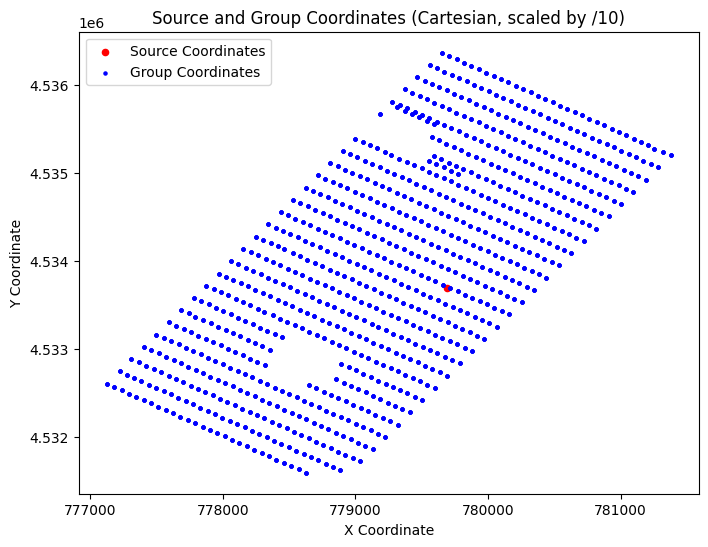

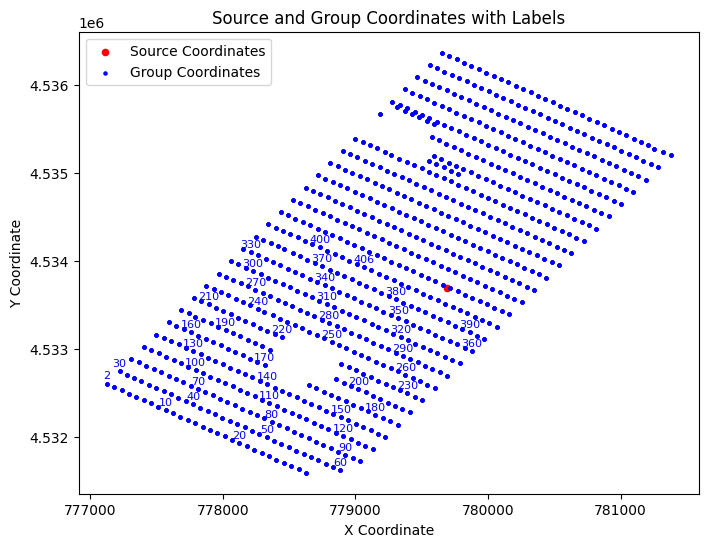


Transformed coordinates to WGS84 (lat, lon). First 5 rows:


source_coordinate_x  source_coordinate_y   latitude   longitude
0             779693.3            4533691.0  39.559103 -118.819645

trace_id  group_coordinate_x  group_coordinate_y   latitude   longitude
0         1                 0.0                 0.0  -1.377653 -125.753742
1         2            777126.0           4532610.5  39.549305 -118.849483
2         3            777180.3           4532572.2  39.548962 -118.848850
3         4            777236.5           4532534.9  39.548627 -118.848195
4         5            777292.0           4532496.8  39.548286 -118.847548

source center coordinate: [39.55910274139133, -118.81964466367452]

Interactive map (ensure the notebook is trusted to visualize):


In [16]:
# Make sure we have headers_df from Step 4
if 'headers_df' not in globals():
    print("No 'headers_df' found. Please run Step 4 first or skip this step.")
else:
    # Extract and Scale Source Coordinates
    if 'source_coordinate_x' not in headers_df.columns or 'source_coordinate_y' not in headers_df.columns:
        print("source_coordinate_x / source_coordinate_y not found in headers_df. Skipping coordinate analysis.")
    else:
        source_coordinate = headers_df[['source_coordinate_x', 'source_coordinate_y']].drop_duplicates().copy()
        source_coordinate['source_coordinate_x'] /= 10
        source_coordinate['source_coordinate_y'] /= 10

        print("Source Coordinates (scaled by /10):")
        display(source_coordinate.head())
        print("------------------------------------------------------------------")

        # Extract and Scale Group/Trace Coordinates
        if 'group_coordinate_x' not in headers_df.columns or 'group_coordinate_y' not in headers_df.columns:
            print("group_coordinate_x / group_coordinate_y not found in headers_df. Skipping group coords.")
        else:
            group_coordinate = headers_df[['group_coordinate_x', 'group_coordinate_y']].copy()
            # Insert trace_id as first column
            group_coordinate.insert(0, 'trace_id', group_coordinate.index + 1)

            # Divide by 10 as well
            group_coordinate['group_coordinate_x'] /= 10
            group_coordinate['group_coordinate_y'] /= 10

            # Print a few rows
            print("Group Coordinates (scaled by /10):")
            display(group_coordinate.head())


            # Basic Cartesian Plot
            filtered_group_coordinate = group_coordinate[
                (group_coordinate['group_coordinate_x'] != 0) |
                (group_coordinate['group_coordinate_y'] != 0)
            ]

            plt.figure(figsize=(8, 6))
            # Plot source in red
            plt.scatter(source_coordinate['source_coordinate_x'],
                        source_coordinate['source_coordinate_y'],
                        color='red', label='Source Coordinates', s=20)
            # Plot group coords in blue
            plt.scatter(filtered_group_coordinate['group_coordinate_x'],
                        filtered_group_coordinate['group_coordinate_y'],
                        color='blue', label='Group Coordinates', s=5)
            plt.xlabel('X Coordinate')
            plt.ylabel('Y Coordinate')
            plt.title("Source and Group Coordinates (Cartesian, scaled by /10)")
            plt.legend()
            plt.show()

            # This labels every 10th coordinate and special trace_ids
            y_offset = 30
            plt.figure(figsize=(8, 6))
            plt.scatter(source_coordinate['source_coordinate_x'],
                        source_coordinate['source_coordinate_y'],
                        color='red', label='Source Coordinates', s=20)
            plt.scatter(filtered_group_coordinate['group_coordinate_x'],
                        filtered_group_coordinate['group_coordinate_y'],
                        color='blue', label='Group Coordinates', s=5)
            for i, row in filtered_group_coordinate.iterrows():
                if (row['trace_id'] % 10 == 0) and (row['trace_id'] < 410) or row['trace_id'] == 2 or row['trace_id'] == 406:
                    plt.text(row['group_coordinate_x'],
                             row['group_coordinate_y'] + y_offset,
                             str(int(row['trace_id'])),
                             color='blue', fontsize=8,
                             verticalalignment='bottom', horizontalalignment='center')
            plt.xlabel('X Coordinate')
            plt.ylabel('Y Coordinate')
            plt.title("Source and Group Coordinates with Labels")
            plt.legend()
            plt.show()

            # Coordinate System Transformation
            # Convert from NAD 1983 State Plane Nevada West (EPSG:32109) to WGS84 (EPSG:4326)
            transformer = Transformer.from_proj(
                proj_from='epsg:32109',
                proj_to='epsg:4326',
                always_xy=True
            )

            def input_to_wgs84(easting, northing):
                lon, lat = transformer.transform(easting, northing)
                return pd.Series([lat, lon])

            # Apply transformation to source
            source_coordinate[['latitude', 'longitude']] = source_coordinate.apply(
                lambda row: input_to_wgs84(row['source_coordinate_x'], row['source_coordinate_y']), axis=1
            )
            # Apply transformation to group coords
            group_coordinate[['latitude', 'longitude']] = group_coordinate.apply(
                lambda row: input_to_wgs84(row['group_coordinate_x'], row['group_coordinate_y']), axis=1
            )

            print("\nTransformed coordinates to WGS84 (lat, lon). First 5 rows:")
            display(source_coordinate.head())
            display(group_coordinate.head())

            # Interactive Folium Map
            # Filter out (0,0) or blank lat/lon
            filtered_geo = group_coordinate[
                (group_coordinate['group_coordinate_x'] != 0) |
                (group_coordinate['group_coordinate_y'] != 0)
            ]

            # Center the map on the average of the source coords (often only one source)
            map_center = [
                source_coordinate['latitude'].mean(),
                source_coordinate['longitude'].mean()
            ]
            print(f"source center coordinate: {map_center}")
            m = folium.Map(location=map_center, zoom_start=10, width='90%', height='90%')

            # Plot the source in red
            for _, row in source_coordinate[['latitude', 'longitude']].iterrows():
                folium.CircleMarker(
                    location=[row['latitude'], row['longitude']],
                    radius=3,
                    popup='Source',
                    color='red',
                    fill=True,
                    fill_color='red',
                    fill_opacity=0.7
                ).add_to(m)

            # Plot group coords in blue
            for _, row in filtered_geo[['latitude', 'longitude', 'trace_id']].iterrows():
                folium.CircleMarker(
                    location=[row['latitude'], row['longitude']],
                    radius=2,
                    popup=str(int(row['trace_id'])),
                    color='blue',
                    fill=True,
                    fill_color='blue',
                    fill_opacity=0.6
                ).add_to(m)

            print("\nInteractive map (ensure the notebook is trusted to visualize):")
            display(m)

## Step 6: Visualizing Seismic Data
Finally, you learn to plot individual traces, compute basic statistics (min, max, mean, etc.), and create a full seismic section “heatmap” to see all traces simultaneously.

Plotting 5 traces, starting at index 0...
Sampling Rate: 500.0 Hz (dt = 0.002 s)


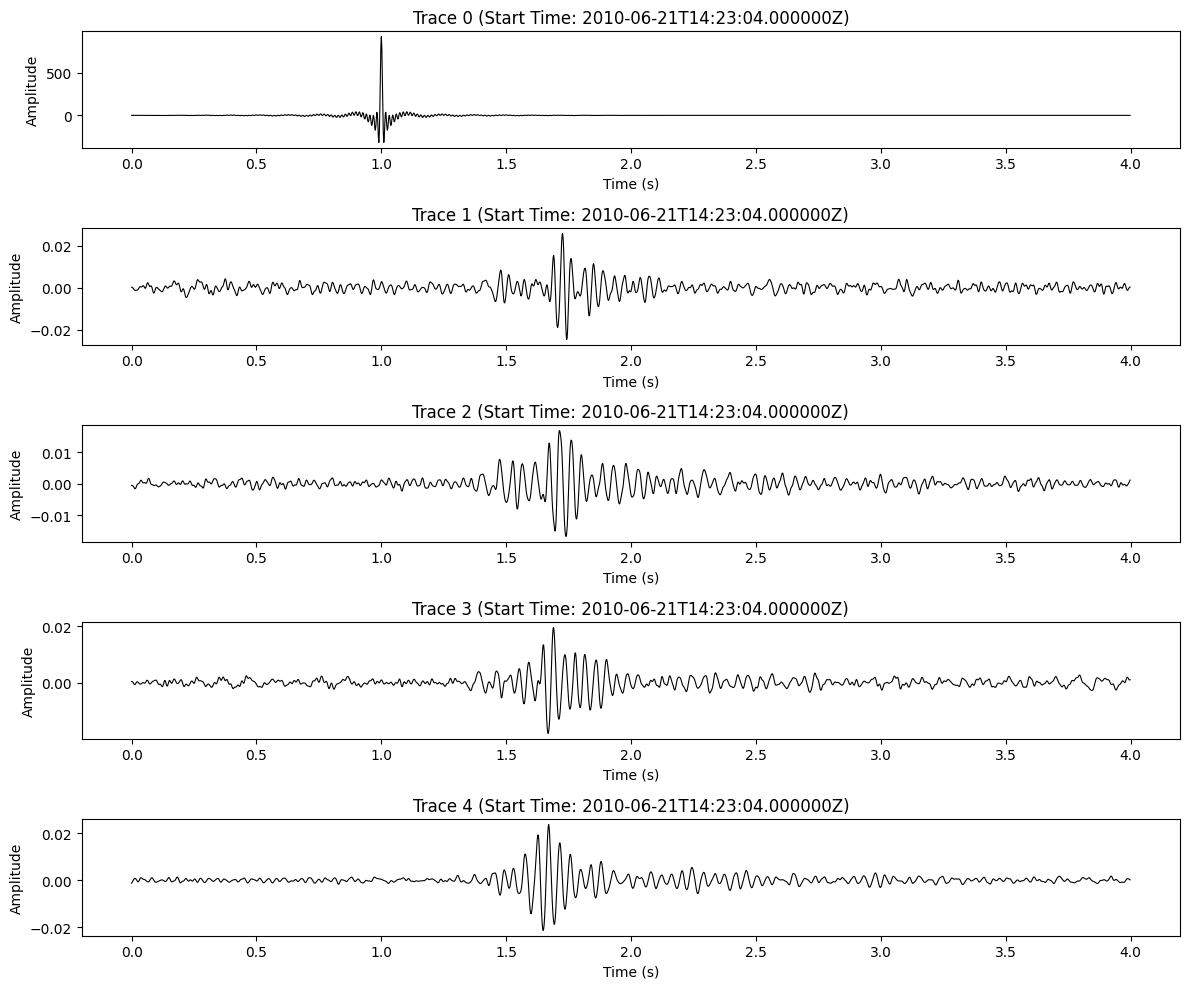


Computing basic stats for all traces in the Stream...
Max: 918.674, Min: -315.566, Mean: 0.000, Std: 0.814
1st percentile: -0.112, 99th percentile: 0.112


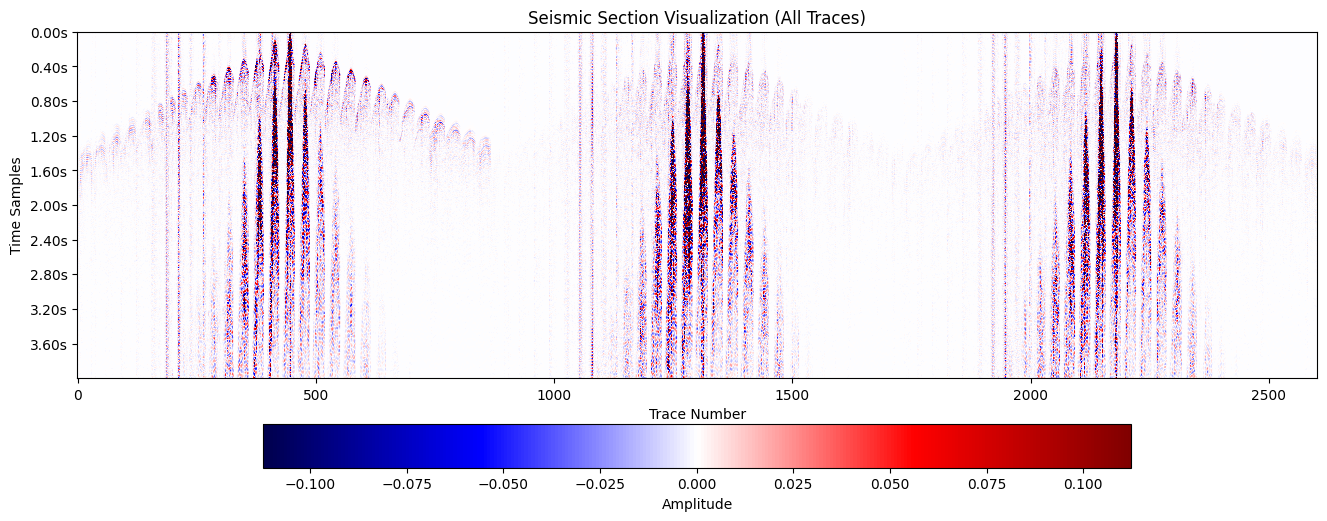

In [18]:
# We'll assume 'data' was loaded in Step 4 with unpacked headers, 
# but if you'd prefer, you can also use 'data_stream_local' or 'data_stream_s3'.

if 'data' not in globals() or data is None:
    raise ValueError("No ObsPy Stream object 'data' found. Please run Step 4 or specify your data Stream.")

# Plot a few Individual Traces
start_number = 0  # which trace index to start with
num_traces_to_plot = 5  # how many traces to plot in subplots

# Grab a subset from the data stream
traces_to_plot = data.traces[start_number:start_number + num_traces_to_plot]

# We can get the sampling interval (seconds) from the first trace
sampling_rate = traces_to_plot[0].stats.sampling_rate
dt = 1.0 / sampling_rate  # sampling interval in seconds

print(f"Plotting {num_traces_to_plot} traces, starting at index {start_number}...")
print(f"Sampling Rate: {sampling_rate} Hz (dt = {dt} s)")

plt.figure(figsize=(12, 10))
for i, trace in enumerate(traces_to_plot, start=1):
    # Generate a time vector in seconds, or a datetime range if you prefer
    npts = len(trace.data)
    # Option A: time in seconds
    times = np.arange(0, npts * dt, dt)
    # Option B (datetime-based): 
    # times = pd.date_range(start=trace.stats.starttime.datetime, periods=npts, freq=pd.Timedelta(seconds=dt))

    ax = plt.subplot(num_traces_to_plot, 1, i)
    ax.plot(times, trace.data, color='k', linewidth=0.8)
    ax.set_title(f"Trace {start_number + i - 1} (Start Time: {trace.stats.starttime})")
    ax.set_xlabel("Time (s)")  # or "Time" if using datetime
    ax.set_ylabel("Amplitude")

    # If you used datetimes, you could format them:
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    # plt.gcf().autofmt_xdate()  # optional

plt.tight_layout()
plt.show()


# Basic Statistics and Outlier Identification
print("\nComputing basic stats for all traces in the Stream...")

try:
    traces_data = np.stack([tr.data for tr in data.traces], axis=1)  # shape (N_samples, N_traces)
    max_val = np.max(traces_data)
    min_val = np.min(traces_data)
    mean_val = np.mean(traces_data)
    std_val = np.std(traces_data)
    print(f"Max: {max_val:.3f}, Min: {min_val:.3f}, Mean: {mean_val:.3f}, Std: {std_val:.3f}")

    # Optional: Print 1st and 99th percentiles
    p1 = np.percentile(traces_data, 1)
    p99 = np.percentile(traces_data, 99)
    print(f"1st percentile: {p1:.3f}, 99th percentile: {p99:.3f}")
except Exception as e:
    print("Error while stacking data or computing stats:", e)
    traces_data = None


# Plot the Entire Seismic Section as an Image
if traces_data is not None:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))

    # We'll clip color range at the 1st and 99th percentiles to better visualize
    vmin, vmax = p1, p99
    seismic_img = ax.imshow(traces_data,
                            cmap='seismic',  # or 'Greys'
                            aspect='auto',   # stretch in X vs Y
                            vmin=vmin,
                            vmax=vmax,
                            origin='upper')  # optional, can be 'lower' or 'upper'

    cbar = plt.colorbar(seismic_img, ax=ax, orientation='horizontal', pad=0.1, shrink=0.7)
    cbar.set_label("Amplitude")

    ax.set_title("Seismic Section Visualization (All Traces)")
    ax.set_xlabel("Trace Number")
    ax.set_ylabel("Time Samples")

    # Optionally, you can label y-axis in seconds:
    #   1) compute #samples from shapes
    #   2) create a time array for the rows
    num_samples = traces_data.shape[0]
    time_axis = np.arange(num_samples) * dt
    # We'll pick a subset of row indices for labeling to avoid clutter
    step = max(num_samples // 10, 1)
    ax.set_yticks(np.arange(0, num_samples, step))
    ax.set_yticklabels(["{:.2f}s".format(t) for t in time_axis[::step]])

    plt.show()